In [4]:
%reload_ext autoreload
%autoreload 2
%reload_ext sql 
%pylab inline
%matplotlib inline
import pylab as pl
import pandas as pd
import os, random

import pickle,time

tmstmp = time.strftime("%m-%d-%Y",time.localtime())



Populating the interactive namespace from numpy and matplotlib


/usr/local/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Initialisation

In [136]:
# Set up the local source files
TOP = os.getcwd().replace('notebooks','')
LIB = TOP+'lib'
if not LIB in sys.path: sys.path.append(LIB)

DAT_DIR = TOP + 'data/'
RES_DIR = TOP + 'results/'
FIG_DIR = TOP + 'figs/'

from organtox import *

DB = openMongo(host='pb.epa.gov',user='devel',passwd='devel',db='organtox_v1')
DB.collection_names()

[u'chm_fp', u'ml_lr_v1', u'bio_fp', u'ml_summary_v1', u'ml_run_v1', u'tox_fp']

In [59]:
Outcomes =[u'CHR:Adrenal Gland',
 u'CHR:Bone Marrow',
 u'CHR:Brain',
 u'CHR:Eye',
 u'CHR:Heart',
 u'CHR:Kidney',
 u'CHR:Liver',
 u'CHR:Lung',
 u'CHR:Lymph Node',
 u'CHR:Mammary Gland',
 u'CHR:Pancreas',
 u'CHR:Pituitary Gland',
 u'CHR:Spleen',
 u'CHR:Stomach',
 u'CHR:Testes',
 u'CHR:Thymus',
 u'CHR:Thyroid Gland',
 u'CHR:Urinary Bladder',
 u'CHR:Uterus',
 u'MGR:Brain',
 u'MGR:Kidney',
 u'MGR:Ovary',
 u'MGR:Testes',
 u'SUB:Adrenal Gland',
 u'SUB:Bone Marrow',
 u'SUB:Brain',
 u'SUB:Heart',
 u'SUB:Kidney',
 u'SUB:Liver',
 u'SUB:Lung',
 u'SUB:Spleen',
 u'SUB:Stomach',
 u'SUB:Testes',
 u'SUB:Thymus',
 u'SUB:Thyroid Gland']
len(Outcomes)

35

## Figure 1. Number of positive and negative examples 

### Count the target organs across all studies

In [54]:
Res = []
TOX = DB.tox_fp.distinct('tox_fpp1.ds')
for tox in TOX:
    n_p,n_n = DB.tox_fp.find({'tox_fpp1.ds':tox}).count(),DB.tox_fp.find({'tox_fpn1.ds':tox}).count()
    s,o=tox.split(':')
    Res.append(dict(study=s,organ=o,val_of='pos',n=n_p))
    Res.append(dict(study=s,organ=o,val_of='neg',n=n_n))
DS_n = pd.pivot_table(pd.DataFrame(Res),index='organ',columns=['study','val_of'],values='n')
DS_n.fillna(0,inplace=True)
DS_n.sort(columns=('CHR','pos'),ascending=True,inplace=True)


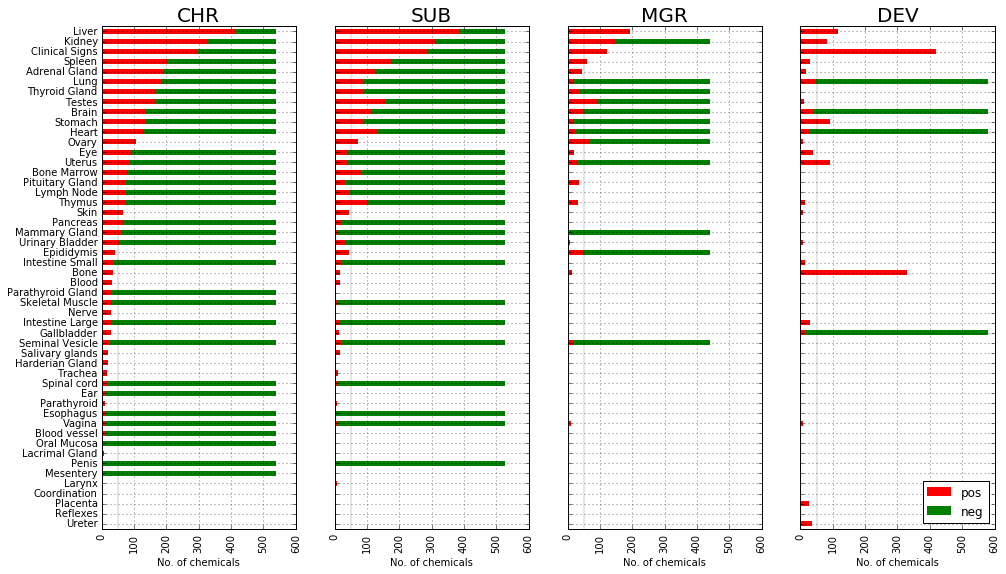

In [139]:
import pylab as pl
fig = pl.figure(figsize=(16,9))
STUDIES=[u'CHR',u'SUB', 'MGR','DEV']
k=0
for s in STUDIES:
    k+=1
    ax=pl.subplot(1,len(STUDIES),k)
    ax.vlines(50,-1,DS_n.shape[0],linestyles='-',lw=0.2)
    DS_n[s][['pos','neg']].ix[:60].plot.barh(stacked=True,legend=False,ax=ax,lw=0, color=['red','green'])
    ax.set_title(s,fontdict=dict(size=20))
    frame1 = plt.gca()
    if k>1: 
        for ylab in ax.get_yticklabels():ylab.set_visible(False)
    for xlab in ax.get_xticklabels():xlab.set_rotation(90)
    ax.set_xlim(0,700)
    ax.set_ylabel('')
    #ax.set_ylim(0,600)
    ax.grid(True)
    ax.set_xlim(0,600)
    ax.set_xlabel('No. of chemicals')
ax.legend(loc=4)
fig.savefig(FIG_DIR+'Figure-1.png')
fig.savefig(FIG_DIR+'Figure-1.svg')

## Figure 2. F1 Score and No of Descriptors

In [121]:
# What are the top classifiers ?

X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},'pt':'cvt','n_obs':100,'n_ds':{'$lt':25}},
                                                dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
#for (pred,dt),P_i in X.groupby(['pred','dt_in']):
for (pred),P_i in X.groupby(['pred']):
    Res = pd.concat((Res,P_i.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf1 = Res.reset_index(drop=True)
Perf1['organ']=Perf1.pred.apply(lambda x:x.split(":")[1])
Perf1['study']=Perf1.pred.apply(lambda x:x.split(":")[0])


F1 0.756544281118 0.0477848713734 0.686516321493 0.838412253321 0.085644646674
Sens 0.842021575752 0.769060328061 0.900040285205 0.126279903634
Spec 0.703251079615 0.609845481405 0.928432562538 0.0827035758773
LR        lr   pct
KNN0   29  83.0
SVCR0   6  17.0
DT      dt_in   pct
bio     10  29.0
bct     10  29.0
bc       8  23.0
ct       7  20.0
Axes(0.125,0.125;0.775x0.775)


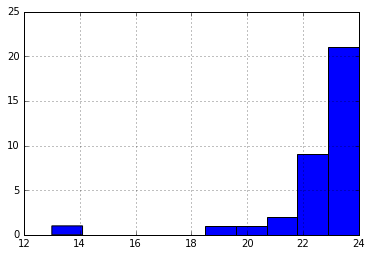

In [122]:
print 'F1', Perf1.f1_mn.mean(),Perf1.f1_mn.std(),Perf1.f1_mn.quantile(q=0.05),Perf1.f1_mn.quantile(q=0.95),\
      np.sqrt((Perf1.f1_sd**2).sum()/Perf1.f1_sd.shape[0])
print 'Sens', Perf1.sens_mn.mean(),Perf1.sens_mn.quantile(q=0.05),Perf1.sens_mn.quantile(q=0.95),\
      np.sqrt((Perf1.sens_sd**2).sum()/Perf1.sens_sd.shape[0])
print 'Spec', Perf1.spec_mn.mean(),Perf1.spec_mn.quantile(q=0.05),Perf1.spec_mn.quantile(q=0.95),\
      np.sqrt((Perf1.spec_sd**2).sum()/Perf1.spec_sd.shape[0])

LR = pd.DataFrame(Perf1.lr.value_counts())
LR['pct']=100*LR.lr/Perf1.shape[0]
print 'LR',LR.round()
DT = pd.DataFrame(Perf1.dt_in.value_counts())
DT['pct']=100*DT.dt_in/Perf1.shape[0]
print 'DT',DT.round()
print Perf1.n_ds.hist()



In [123]:
Perf1['clf_id']=Perf1.apply(lambda x: "%s:%d/%s/%s:%d" % (x['pred'],x['n_obs'],x['lr'],x['dt_in'],x['n_ds']),axis=1)
Perf2 = Perf1.set_index(['clf_id','pred','lr','dt_in','n_ds','n_obs'])
Perf2.sort(columns=['f1_mn','sens_mn','spec_mn'],ascending=False,inplace=True)
#Perf2[['f1_mn','f1_sd','sens_mn','sens_sd','spec_mn','spec_sd']].to_excel(DAT_DIR+'Table-1-cvt.xlsx')


MGR:Brain SVCR0
CHR:Urinary Bladder SVCR0
CHR:Mammary Gland SVCR0
CHR:Pancreas KNN0
SUB:Bone Marrow KNN0
CHR:Lymph Node KNN0
MGR:Ovary KNN0
CHR:Thymus KNN0
CHR:Bone Marrow KNN0
CHR:Uterus KNN0
SUB:Lung KNN0
MGR:Testes KNN0
SUB:Stomach KNN0
CHR:Pituitary Gland KNN0
SUB:Thyroid Gland KNN0
CHR:Eye KNN0
SUB:Thymus KNN0
SUB:Adrenal Gland KNN0
CHR:Heart KNN0
SUB:Brain KNN0
SUB:Heart KNN0
CHR:Liver SVCR0
CHR:Stomach KNN0
SUB:Testes KNN0
MGR:Kidney KNN0
SUB:Liver SVCR0
CHR:Brain KNN0
CHR:Thyroid Gland KNN0
SUB:Spleen KNN0
CHR:Lung KNN0
CHR:Testes KNN0
CHR:Adrenal Gland KNN0
CHR:Kidney SVCR0
CHR:Spleen KNN0
SUB:Kidney KNN0


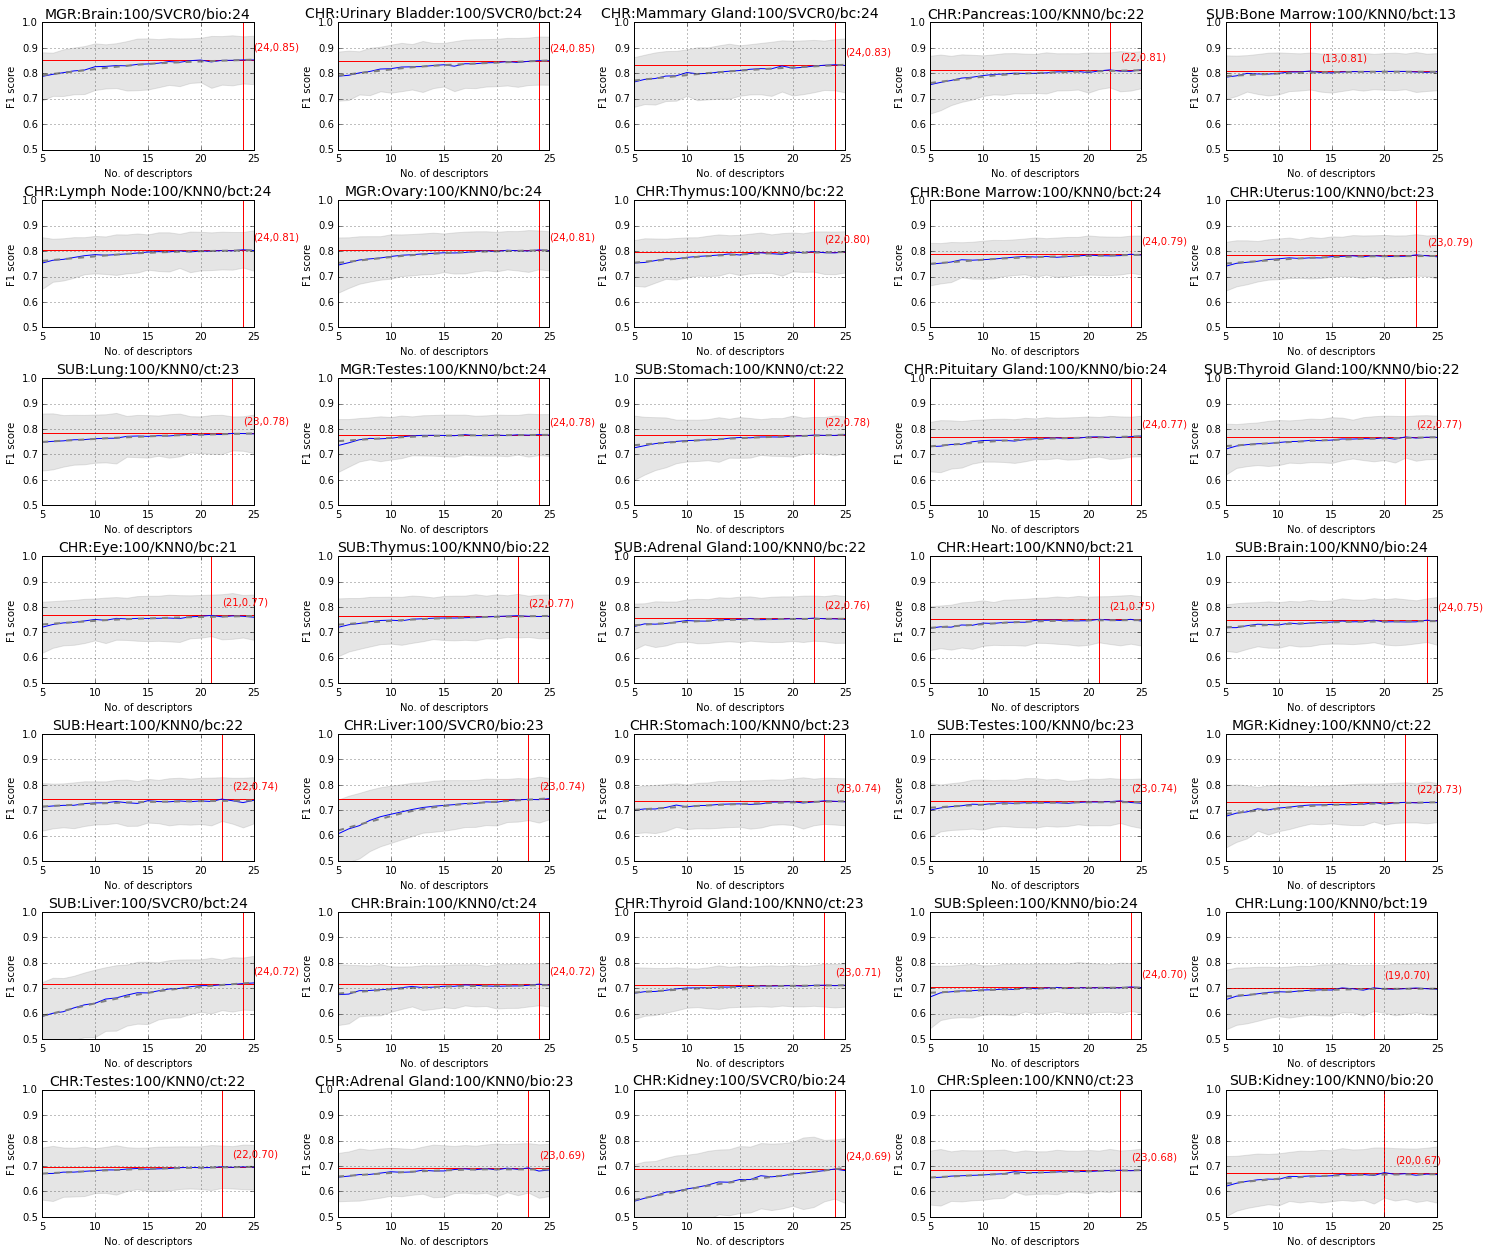

In [140]:
# Relationship with n_obs

import statsmodels.api as sm
def mySmooth(x1,y1):
    return sm.nonparametric.lowess(y1,x1,return_sorted=False,it=3,delta=0.4)

fig = pl.figure(figsize=(25,30))
i=0
for clf_id,pred,lr,dt_in,n_ds,n_obs in list(Perf2.index):
    i+=1
    #if i>5: break
    print pred,lr
    X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':pred,'pt':'cvt',
                                                 'lr':lr,
                                                 'n_obs':n_obs,'dt_in':dt_in},
                                                 dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

    ax = pl.subplot(10,5,i)
    ax.plot(X.n_ds,X.f1_mn)
    ax.plot(X.n_ds,mySmooth(X.n_ds,X.f1_mn),ls='--',lw=2,color='grey')
    ax.fill_between(X.n_ds,X.f1_mn-X.f1_sd,X.f1_mn+X.f1_sd,color='grey',alpha=0.2)
    ax.set_ylim(0.5,1)
    ax.grid('on')
    ax.set_title(clf_id,fontdict=dict(size=14))
    ax.set_xlabel('No. of descriptors')
    ax.set_ylabel('F1 score')
    y=X.query('n_ds==%d'%n_ds).f1_mn
    x1,x2=X.n_ds.min(),X.n_ds.max()
    ax.hlines(y,x1,x2,colors='red')
    ax.vlines(n_ds,0.5,1,colors='red')
    ax.text(n_ds+1,y+0.04,"(%d,%3.2f)" % (n_ds,y),color='red',fontdict=dict(size=10))

pl.subplots_adjust(wspace=0.4,hspace=0.4,top=0.9,bottom=0.1)
fig.savefig(FIG_DIR+'Figure-2.png')
fig.savefig(FIG_DIR+'Figure-2.svg')


In [125]:
# Results: Machine Learning 

# What are the top classifiers ?

X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},'pt':'cvt','n_ds':{'$lt':25},'n_obs':100},
                                             dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
#for (pred,dt),P_i in X.groupby(['pred','dt_in']):
for (pred),P_i in X.groupby(['pred']):
    Res = pd.concat((Res,P_i.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf1 = Res.reset_index(drop=True)
                                             

F1 0.756544281118 0.0477848713734 0.686516321493 0.838412253321 0.085644646674
Sens 0.842021575752 0.769060328061 0.900040285205 0.126279903634
Spec 0.703251079615 0.609845481405 0.928432562538 0.0827035758773
LR        lr   pct
KNN0   29  83.0
SVCR0   6  17.0
DT      dt_in   pct
bio     10  29.0
bct     10  29.0
bc       8  23.0
ct       7  20.0
Axes(0.125,0.125;0.775x0.775)


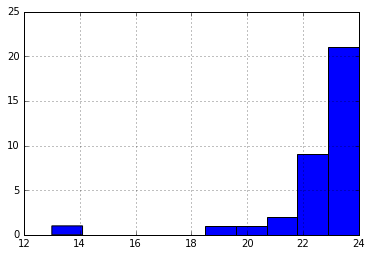

In [126]:
print 'F1', Perf1.f1_mn.mean(),Perf1.f1_mn.std(),Perf1.f1_mn.quantile(q=0.05),Perf1.f1_mn.quantile(q=0.95),\
      np.sqrt((Perf1.f1_sd**2).sum()/Perf1.f1_sd.shape[0])
print 'Sens', Perf1.sens_mn.mean(),Perf1.sens_mn.quantile(q=0.05),Perf1.sens_mn.quantile(q=0.95),\
      np.sqrt((Perf1.sens_sd**2).sum()/Perf1.sens_sd.shape[0])
print 'Spec', Perf1.spec_mn.mean(),Perf1.spec_mn.quantile(q=0.05),Perf1.spec_mn.quantile(q=0.95),\
      np.sqrt((Perf1.spec_sd**2).sum()/Perf1.spec_sd.shape[0])

LR = pd.DataFrame(Perf1.lr.value_counts())
LR['pct']=100*LR.lr/Perf1.shape[0]
print 'LR',LR.round()
DT = pd.DataFrame(Perf1.dt_in.value_counts())
DT['pct']=100*DT.dt_in/Perf1.shape[0]
print 'DT',DT.round()
print Perf1.n_ds.hist()

## Table 1. Optimal Classifiers / 100

In [127]:
# What are the top classifiers by pred, dt and ?
X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},
                                             'pt':'cvt','n_obs':100,'n_ds':{'$lt':25}},
                                                dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
for (pred),P_i in X.groupby(['pred']):
    for (dt), P_ij in P_i.groupby(['dt_in']):
        for (lr),P_ijk in P_ij.groupby(['lr']):
            Res = pd.concat((Res,P_ijk.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf1 = Res.reset_index(drop=True)




Perf1['res2']=Perf1.apply(lambda x: "%s:%d/%s/%s:%d" % (x.pred,x.n_obs,x.lr,x.dt_in,x.n_ds),axis=1)
Perf1['res2_f1']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.f1_mn,x.f1_sd),axis=1)
Perf1['res2_sn']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.sens_mn,x.sens_sd),axis=1)
Perf1['res2_sp']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.spec_mn,x.spec_sd),axis=1)

P1 = None
for p in Perf1.pred.unique():
    P1 = pd.concat((P1,Perf1.query("pred=='%s'" % p).sort('f1_mn',ascending=False).head(1)))

In [130]:
P1.head()

,acc_mn,acc_sd,bacc_mn,bacc_sd,dt_in,f1_mn,f1_sd,lr,n_ds,n_obs,pred,sens_mn,sens_sd,spec_mn,spec_sd,res2,res2_f1,res2_sn,res2_sp
18,0.649505,0.099312,0.707124,0.098002,bio,0.692457,0.097200,KNN0,23,100,CHR:Adrenal Gland,0.769158,0.146680,0.645089,0.096149,CHR:Adrenal Gland:100/KNN0/bio:23,0.69±0.10,0.77±0.15,0.65±0.10
50,0.716796,0.087636,0.800728,0.073463,bct,0.787910,0.073129,KNN0,24,100,CHR:Bone Marrow,0.885475,0.104164,0.715981,0.074972,CHR:Bone Marrow:100/KNN0/bct:24,0.79±0.07,0.89±0.10,0.72±0.07
114,0.634756,0.092942,0.740913,0.085071,ct,0.715611,0.083533,KNN0,24,100,CHR:Brain,0.859999,0.132434,0.621828,0.079689,CHR:Brain:100/KNN0/ct:24,0.72±0.08,0.86±0.13,0.62±0.08
122,0.702385,0.090102,0.777526,0.081810,bc,0.766621,0.081641,KNN0,21,100,CHR:Eye,0.837915,0.124067,0.717138,0.080726,CHR:Eye:100/KNN0/bc:21,0.77±0.08,0.84±0.12,0.72±0.08
170,0.704327,0.096484,0.761763,0.089683,bct,0.751223,0.090594,KNN0,21,100,CHR:Heart,0.807889,0.127729,0.715638,0.093209,CHR:Heart:100/KNN0/bct:21,0.75±0.09,0.81±0.13,0.72±0.09


In [165]:
P1.f1_mn.mean()

0.7565442811183286

In [131]:
LR = pd.DataFrame(P1.lr.value_counts())
LR['pct']=100*LR.lr/P1.shape[0]
print 'LR',LR.round()
print

DT = pd.DataFrame(P1.dt_in.value_counts())
DT['pct']=100*DT.dt_in/P1.shape[0]
print 'DT',DT.round()

LR        lr   pct
KNN0   29  83.0
SVCR0   6  17.0

DT      dt_in   pct
bio     10  29.0
bct     10  29.0
bc       8  23.0
ct       7  20.0


In [146]:
##Table 1
#P1.sort('f1_mn',ascending=False)[['res2','pred','lr','dt_in','n_ds','res2_f1','res2_sn','res2_sp']].to_csv(DAT_DIR+'table-1_2.csv')
Table1 = P1.sort('f1_mn',ascending=False)[['res2','pred','lr','dt_in','n_ds','res2_f1','res2_sn','res2_sp']]
Table1.columns=['Classifier id','Organ Toxicity','Algorithm','dt','n_ds','F1 Score','Sensitivity','Specificity']
#Table1.to_excel(DAT_DIR+'Table-1.xlsx',encoding='utf8')
Table1

,Classifier id,Organ Toxicity,Algorithm,dt,n_ds,F1 Score,Sensitivity,Specificity
783,MGR:Brain:100/SVCR0/bio:24,MGR:Brain,SVCR0,bio,24,0.85±0.09,0.79±0.13,0.95±0.06
695,CHR:Urinary Bladder:100/SVCR0/bct:24,CHR:Urinary Bladder,SVCR0,bct,24,0.85±0.09,0.80±0.13,0.93±0.07
367,CHR:Mammary Gland:100/SVCR0/bc:24,CHR:Mammary Gland,SVCR0,bc,24,0.83±0.10,0.77±0.14,0.93±0.07
402,CHR:Pancreas:100/KNN0/bc:22,CHR:Pancreas,KNN0,bc,22,0.81±0.07,0.89±0.10,0.75±0.07
970,SUB:Bone Marrow:100/KNN0/bct:13,SUB:Bone Marrow,KNN0,bct,13,0.81±0.07,0.90±0.10,0.74±0.07
330,CHR:Lymph Node:100/KNN0/bct:24,CHR:Lymph Node,KNN0,bct,24,0.81±0.07,0.89±0.10,0.74±0.07
842,MGR:Ovary:100/KNN0/bc:24,MGR:Ovary,KNN0,bc,24,0.81±0.08,0.87±0.11,0.75±0.07
602,CHR:Thymus:100/KNN0/bc:22,CHR:Thymus,KNN0,bc,22,0.80±0.08,0.87±0.11,0.75±0.08
50,CHR:Bone Marrow:100/KNN0/bct:24,CHR:Bone Marrow,KNN0,bct,24,0.79±0.07,0.89±0.10,0.72±0.07
730,CHR:Uterus:100/KNN0/bct:23,CHR:Uterus,KNN0,bct,23,0.79±0.08,0.86±0.12,0.73±0.08


In [28]:
Perf1['organ']=Perf1.pred.apply(lambda x:x.split(":")[1])
Perf1['study']=Perf1.pred.apply(lambda x:x.split(":")[0])


P2 = pd.pivot_table(Perf1,index=['organ','dt_in','lr','n_ds'],
               columns=['study'],
               values='f1_mn',
               aggfunc=np.mean)
P2.ix[:10]

study                                CHR  MGR       SUB
organ         dt_in lr    n_ds                         
Adrenal Gland bc    CART0 21    0.668436  NaN       NaN
                          22         NaN  NaN  0.737024
                    CART1 22    0.676669  NaN  0.736878
                    KNN0  15    0.712927  NaN       NaN
                          20         NaN  NaN  0.749230
                    KNN1  15    0.702109  NaN       NaN
                          20         NaN  NaN  0.732719
                    NB    8     0.622161  NaN       NaN
                          24         NaN  NaN  0.619131
                    RF0   22    0.672647  NaN       NaN

# Optimal Classifiers 

In [98]:
# What are the top classifiers by pred, dt and ?
X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},
                                             'pt':'cvt',
                                             'n_obs':{'$gte':100},
                                             'n_ds':{'$lt':25}},
                                                dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
for (pred),P_i in X.groupby(['pred']):
    for (dt), P_ij in P_i.groupby(['dt_in']):
        for (lr),P_ijk in P_ij.groupby(['lr']):
            Res = pd.concat((Res,P_ijk.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf1 = Res.reset_index(drop=True)




In [99]:
Perf1['res2']=Perf1.apply(lambda x: "%s:%d/%s/%s:%d" % (x.pred,x.n_obs,x.lr,x.dt_in,x.n_ds),axis=1)
Perf1['res2_f1']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.f1_mn,x.f1_sd),axis=1)
Perf1['res2_sn']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.sens_mn,x.sens_sd),axis=1)
Perf1['res2_sp']=Perf1.apply(lambda x: "%3.2f±%3.2f" % (x.spec_mn,x.spec_sd),axis=1)

In [100]:
P1 = None
for p in Perf1.pred.unique():
    P1 = pd.concat((P1,Perf1.query("pred=='%s'" % p).sort('f1_mn',ascending=False).head(1)))

In [101]:
##Table 1
P1.sort('f1_mn',ascending=False)[['res2','pred','lr','dt_in','n_obs','n_ds','res2_f1','res2_sn','res2_sp']].to_csv(DAT_DIR+'table-2.csv')

In [102]:
LR = pd.DataFrame(P1.lr.value_counts())
LR['pct']=100*LR.lr/P1.shape[0]
print 'LR',LR.round()
print

DT = pd.DataFrame(P1.dt_in.value_counts())
DT['pct']=100*DT.dt_in/P1.shape[0]
print 'DT',DT.round()

LR        lr   pct
SVCR0  13  57.0
KNN0    7  30.0
RF0     3  13.0

DT      dt_in   pct
bct     12  52.0
bio      7  30.0
bc       3  13.0
ct       1   4.0


In [148]:
Perf1['res1']=Perf1.apply(lambda x: "F1:%4.2f(%4.2f) Sn:%3.2f(%3.2f) Sp:%3.2f(%3.2f)" % \
                          (x.f1_mn,x.f1_sd,x.sens_mn,x.sens_sd,x.spec_mn,x.spec_sd),axis=1)

#Y2=pd.pivot_table(Perf1,index='pred',columns=['lr','dt_in'],values='res1',aggfunc=lambda x: np.unique(x)[0])
Perf2=pd.pivot_table(Perf1,index='pred',columns=['lr','dt_in'],values=['f1_mn','res1'],aggfunc=lambda x: np.unique(x)[0])
Perf2.head()
Y1 = Perf2['f1_mn'].max(axis=1)
Y1.sort(ascending=False)

Perf3 = Perf2['res1'][[u'NB', u'KNN0', u'KNN1',  u'RF0',u'CART0', u'CART1', u'SVCL0',u'SVCR0']].ix[Y1.index]
Perf3.to_excel(DAT_DIR+'ST5.xlsx')
Perf3.head()

lr                                                          NB  \
dt_in                                                       bc   
pred                                                             
MGR:Brain            F1:0.78(0.11) Sn:0.83(0.16) Sp:0.77(0.09)   
CHR:Urinary Bladder  F1:0.76(0.14) Sn:0.81(0.19) Sp:0.76(0.12)   
CHR:Mammary Gland    F1:0.72(0.16) Sn:0.75(0.22) Sp:0.77(0.13)   
CHR:Pancreas         F1:0.73(0.14) Sn:0.75(0.21) Sp:0.76(0.11)   
SUB:Bone Marrow      F1:0.71(0.16) Sn:0.74(0.20) Sp:0.74(0.15)   

lr                                                              \
dt_in                                                      bct   
pred                                                             
MGR:Brain            F1:0.79(0.11) Sn:0.84(0.16) Sp:0.76(0.09)   
CHR:Urinary Bladder  F1:0.77(0.12) Sn:0.83(0.16) Sp:0.76(0.10)   
CHR:Mammary Gland    F1:0.74(0.13) Sn:0.77(0.19) Sp:0.78(0.11)   
CHR:Pancreas         F1:0.74(0.12) Sn:0.79(0.18) Sp:0.74(0.09)   
SUB:Bone Marrow      F1:0.75(0.12) Sn:0.82(0.17) Sp:0.72(0.10)   

lr                                                              \
dt_in                                                      bio   
pred                                                             
MGR:Brain            F1:0.79(0.12) Sn:0.84(0.16) Sp:0.77(0.09)   
CHR:Urinary Bladder  F1:0.78(0.12) Sn:0.84(0.15) Sp:0.77(0.10)   
CHR:Mammary Gland    F1:0.70(0.16) Sn:0.74(0.23) Sp:0.72(0.14)   
CHR:Pancreas         F1:0.72(0.14) Sn:0.76(0.20) Sp:0.73(0.11)   
SUB:Bone Marrow      F1:0.76(0.12) Sn:0.82(0.17) Sp:0.73(0.10)   

lr                                                              \
dt_in                                                      chm   
pred                                                             
MGR:Brain            F1:0.72(0.19) Sn:0.78(0.25) Sp:0.74(0.15)   
CHR:Urinary Bladder  F1:0.77(0.14) Sn:0.85(0.19) Sp:0.74(0.12)   
CHR:Mammary Gland    F1:0.65(0.19) Sn:0.68(0.27) Sp:0.73(0.16)   
CHR:Pancreas         F1:0.65(0.18) Sn:0.65(0.24) Sp:0.76(0.16)   
SUB:Bone Marrow      F1:0.68(0.16) Sn:0.76(0.24) Sp:0.69(0.14)   

lr                                                              \
dt_in                                                       ct   
pred                                                             
MGR:Brain            F1:0.77(0.12) Sn:0.86(0.16) Sp:0.72(0.12)   
CHR:Urinary Bladder  F1:0.75(0.16) Sn:0.81(0.21) Sp:0.76(0.12)   
CHR:Mammary Gland    F1:0.73(0.15) Sn:0.78(0.21) Sp:0.75(0.11)   
CHR:Pancreas         F1:0.78(0.11) Sn:0.89(0.16) Sp:0.71(0.09)   
SUB:Bone Marrow      F1:0.70(0.15) Sn:0.74(0.19) Sp:0.74(0.15)   

lr                                                        KNN0  \
dt_in                                                       bc   
pred                                                             
MGR:Brain            F1:0.84(0.07) Sn:0.91(0.10) Sp:0.78(0.07)   
CHR:Urinary Bladder  F1:0.83(0.06) Sn:0.92(0.09) Sp:0.76(0.06)   
CHR:Mammary Gland    F1:0.83(0.07) Sn:0.90(0.10) Sp:0.77(0.07)   
CHR:Pancreas         F1:0.81(0.07) Sn:0.89(0.10) Sp:0.75(0.07)   
SUB:Bone Marrow      F1:0.80(0.07) Sn:0.88(0.10) Sp:0.75(0.08)   

lr                                                              \
dt_in                                                      bct   
pred                                                             
MGR:Brain            F1:0.84(0.07) Sn:0.91(0.10) Sp:0.78(0.07)   
CHR:Urinary Bladder  F1:0.83(0.07) Sn:0.91(0.09) Sp:0.77(0.07)   
CHR:Mammary Gland    F1:0.83(0.07) Sn:0.89(0.10) Sp:0.78(0.07)   
CHR:Pancreas         F1:0.81(0.07) Sn:0.89(0.10) Sp:0.75(0.07)   
SUB:Bone Marrow      F1:0.81(0.07) Sn:0.90(0.10) Sp:0.74(0.07)   

lr                                                              \
dt_in                                                      bio   
pred                                                             
MGR:Brain            F1:0.84(0.06) Sn:0.92(0.09) Sp:0.78(0.07)   
CHR:Urinary Bladder  F1:0.83(0.06

In [229]:
study = '^SUB|^MGR'
PRED=[i for i in Outcomes_paper if re.search(study,i,re.I)]
PRED

[u'MGR:Brain',
 u'MGR:Kidney',
 u'MGR:Ovary',
 u'MGR:Testes',
 u'SUB:Adrenal Gland',
 u'SUB:Bone Marrow',
 u'SUB:Brain',
 u'SUB:Heart',
 u'SUB:Kidney',
 u'SUB:Liver',
 u'SUB:Lung',
 u'SUB:Spleen',
 u'SUB:Stomach',
 u'SUB:Testes',
 u'SUB:Thymus',
 u'SUB:Thyroid Gland']

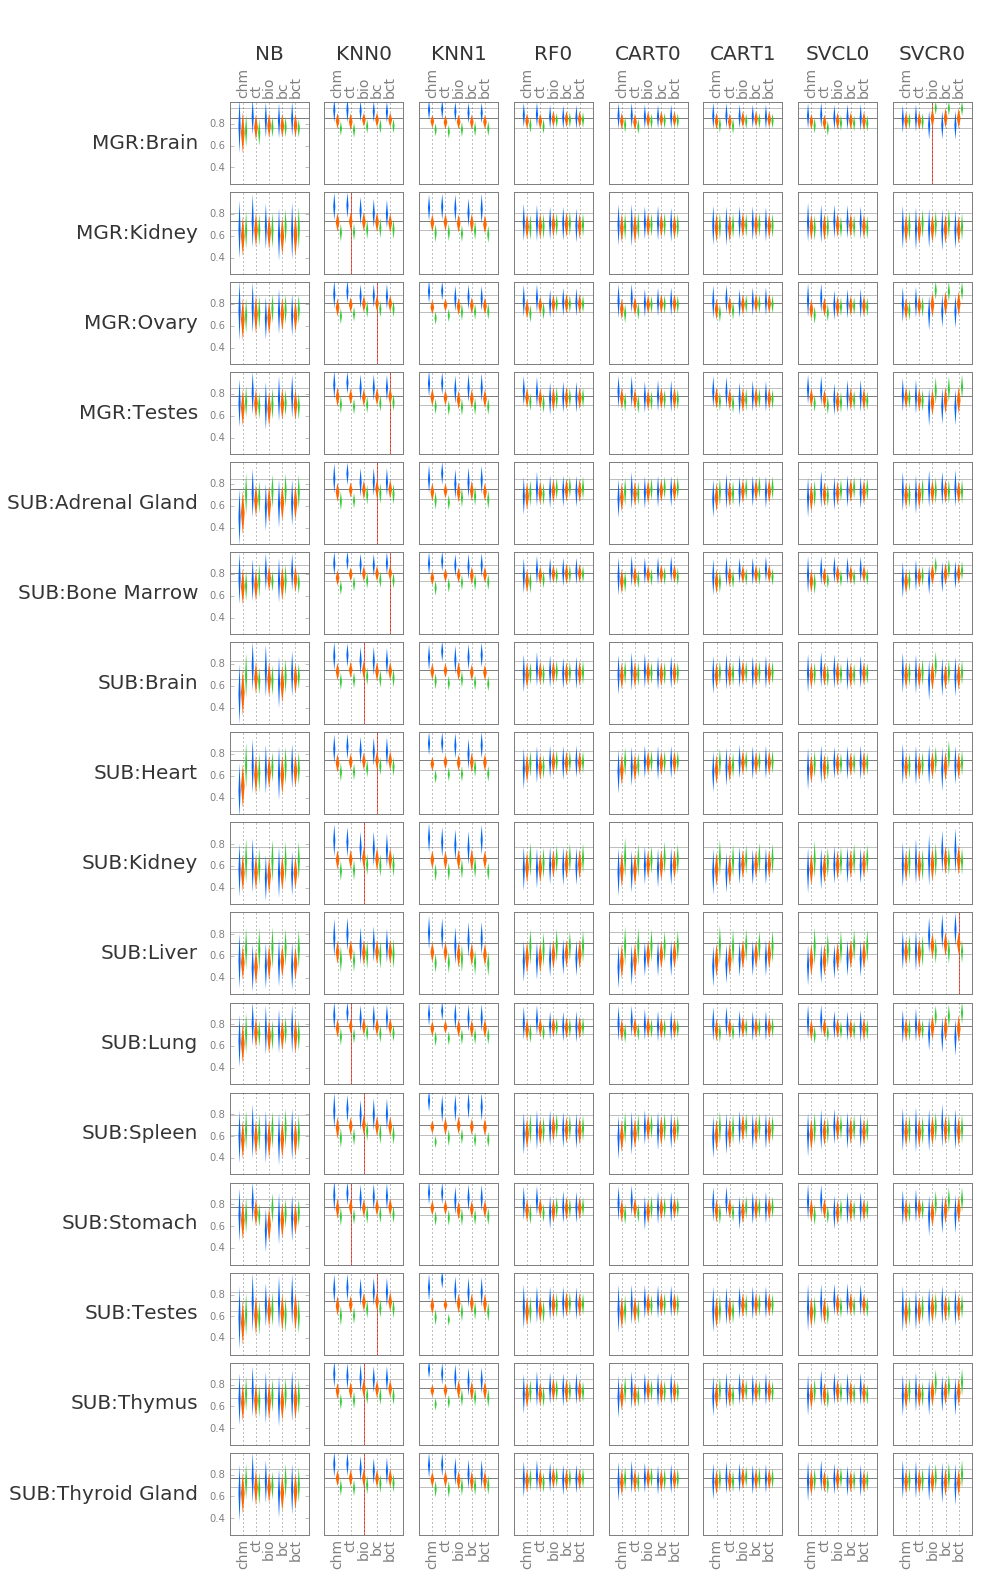

In [151]:
import matplotlib.gridspec as gridspec
import pylab as pl
import statsmodels.api as sm
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Ellipse, Circle
from matplotlib.collections import PatchCollection
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.text as text
import matplotlib.font_manager as fm 
import pylab as pl

def setAxisCol(ax,col='grey'):
    ax.tick_params(color=col, labelcolor=col)
    for spine in ax.spines.values():
        spine.set_edgecolor(col)


#LR= ['NB','KNN0','RF0','CART1','SVCR0']

X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},
                                             'pt':'cvt','n_obs':100,'n_ds':{'$lt':25}},
                                                dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
for (pred,dt,lr),P_i in X.groupby(['pred','dt_in','lr']):
    Res = pd.concat((Res,P_i.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf1 = Res.reset_index(drop=True)

for c in ['f1','sens','spec']:
    Perf1['%s_top' % c] = Perf1['%s_mn' % c]+Perf1['%s_sd' % c]
    Perf1['%s_bot' % c] = Perf1['%s_mn' % c]-Perf1['%s_sd' % c]

LR = Perf1.lr.unique()
LR = [i for i in [u'NB', u'KNN0', u'KNN1',  u'RF0',u'CART0', u'CART1', u'SVCL0',u'SVCR0'] if i in LR]
DT = ['chm','ct','bio','bc','bct']

fig = pl.figure(figsize=(15,28))

#study = '^CHR'
study = '^SUB|^MGR'
PRED=[i for i in Outcomes if re.search(study,i,re.I)]

gs1 = gridspec.GridSpec(len(PRED)+2,len(LR)+1)#,width_ratios=[1,0.5,1],height_ratios=[1,2,1])


for c_i,lr in enumerate(LR):
    
    ax = pl.subplot(gs1[0,c_i+1])
    ax.set_axis_off()
    ax.text(50,30,lr,fontdict=dict(size=20,color='#343434',horizontalalignment='center',verticalalignment='top'))
    ax.set_ylim(0,50)
    ax.set_xlim(0,100)
    #ax.set_aspect(1.5)

r_i = -1
for pred in PRED:
    
    P_best = Perf1.query("pred=='%s'" % pred).sort('f1_mn',ascending=False).reset_index(drop=True).head(1)
    if P_best.shape[0]==0: continue
    P_best=P_best.ix[0]
    best_lr = best_dt = False
    r_i += 1
    ax = pl.subplot(gs1[r_i+1,0])
    ax.set_axis_off()
    ax.text(40,25,pred,fontdict=dict(size=20,color='#343434',horizontalalignment='right',verticalalignment='center'))
    ax.set_ylim(0,50)
    ax.set_xlim(0,50)
    
    for c_i,lr in enumerate(LR):
        ax = pl.subplot(gs1[r_i+1,c_i+1])
        #ax.set_xlim(0,1)
        ax.set_ylim(0.25,1)
        ax.set_xlim(0,len(DT)+1)
        #ax.set_aspect(1.5)
        ax.grid('on',axis='x')
        setAxisCol(ax,'grey')
        #if r_i==0: ax.set_title(dt,fontdict=dict(size=20,color='#343434'))
        
        P = Perf1.query("pred=='%s' and lr=='%s'" % (pred,lr))
        best_lr = True if lr == P_best.lr else False
        ax.hlines(P_best.f1_mn,0,len(DT)+1,colors='grey',lw=1,linestyles='-',zorder=0)
        ax.hlines(P_best.f1_top,0,len(DT)+1,colors='grey',lw=0.5,linestyles='-',zorder=0)
        ax.hlines(P_best.f1_bot,0,len(DT)+1,colors='grey',lw=0.5,linestyles='-',zorder=0)
        
        for i,dt in enumerate(DT):
            
            best_dt = True if dt == P_best.dt_in and best_lr else False
                
            x = i+1
            P_i = P.query("dt_in=='%s'" % dt)
            
            if best_dt and best_lr: ax.vlines(x,0.25,1,colors='#ff6655',lw=1,zorder=0)
            
            if P_i.shape[0]==0: continue
            XY_f1= np.array([[x,P_i.f1_top],[x+0.14,float(P_i.f1_mn)],[x,P_i.f1_bot],[x-0.14,float(P_i.f1_mn)]])
            ax.add_patch(mpatches.Polygon(XY_f1,lw=0,color='#ff6600',zorder=10,alpha=1))
            
            x = i+0.75
            XY_sn= np.array([[x,P_i.sens_top],[x+0.08,float(P_i.sens_mn)],[x,P_i.sens_bot],[x-0.08,float(P_i.sens_mn)]])
            ax.add_patch(mpatches.Polygon(XY_sn,lw=0,color='#0066ff',zorder=10,alpha=1))
            
            x = i+1.25
            XY_sp= np.array([[x,P_i.spec_top],[x+0.08,float(P_i.spec_mn)],[x,P_i.spec_bot],[x-0.08,float(P_i.spec_mn)]])
            ax.add_patch(mpatches.Polygon(XY_sp,lw=0,color='#33cc33',zorder=10,alpha=1))
            
        
        ax.set_xticks(np.arange(len(DT))+1, minor=False)
        for tick in ax.get_xticklines(): tick.set_visible(False)
        
        if c_i == 0:
            ax.set_yticks([0.4,0.6,0.8], minor=False)
        else:
            for tick in ax.get_yticklabels(): tick.set_visible(False)
            for tick in ax.get_yticklines(): tick.set_visible(False)
                
        if r_i == 0:
            ax.xaxis.tick_top()
            ax.set_xticklabels(DT,rotation=90)
            for tick in ax.get_xticklabels(): tick.set_fontsize(14)
        elif r_i == len(PRED)-1:
            ax.xaxis.tick_bottom()
            ax.set_xticklabels(DT,rotation=90)
            for tick in ax.get_xticklabels(): tick.set_fontsize(14)
        else:
            for tick in ax.get_xticklabels(): tick.set_visible(False)

        
pl.subplots_adjust(wspace=0.2,hspace=0.1,top=0.9,bottom=0.1)
fig.savefig(FIG_DIR+'Figure-3-%s.png' % study.replace('|','-'),dpi=600)
fig.savefig(FIG_DIR+'Figure-3-%s.svg' % study.replace('|','-'),dpi=600)


## Table 2. Optimal Classifiers / Max 

In [747]:
# What are the top classifiers by pred, dt and ?
X = pd.DataFrame(list(DB.ml_summary_v1.find({'pred':{'$in':Outcomes},
                                             'pt':'cvt','n_obs':{'$gt':100},'n_ds':{'$lt':25}},
                                                dict(_id=0,pt=0,n_pos=0,n_neg=0,dt_out=0))))

Res = None
for (pred),P_i in X.groupby(['pred']):
    for (dt), P_ij in P_i.groupby(['dt_in']):
        for (lr),P_ijk in P_ij.groupby(['lr']):
            Res = pd.concat((Res,P_ijk.sort('f1_mn',ascending=False).reset_index(drop=True).head(1)))
Perf4 = Res.reset_index(drop=True)




Perf4['res2']=Perf4.apply(lambda x: "%s:%d/%s/%s:%d" % (x.pred,x.n_obs,x.lr,x.dt_in,x.n_ds),axis=1)
Perf4['res2_f1']=Perf4.apply(lambda x: "%3.2f±%3.2f" % (x.f1_mn,x.f1_sd),axis=1)
Perf4['res2_sn']=Perf4.apply(lambda x: "%3.2f±%3.2f" % (x.sens_mn,x.sens_sd),axis=1)
Perf4['res2_sp']=Perf4.apply(lambda x: "%3.2f±%3.2f" % (x.spec_mn,x.spec_sd),axis=1)

P4 = None
for p in Perf4.pred.unique():
    P4 = pd.concat((P4,Perf4.query("pred=='%s'" % p).sort('f1_mn',ascending=False).head(1)))

In [749]:
Table2 = P4.sort('f1_mn',ascending=False)[['res2','pred','lr','dt_in','n_ds','res2_f1','res2_sn','res2_sp']]
Table2.columns=['Classifier id','Organ Toxicity','Algorithm','dt','n_ds','F1 Score','Sensitivity','Specificity']
#Table2.to_excel(DAT_DIR+'Table-1.xlsx',encoding='utf8')
Table2

,Classifier id,Organ Toxicity,Algorithm,dt,n_ds,F1 Score,Sensitivity,Specificity
983,SUB:Bone Marrow:164/SVCR0/bio:23,SUB:Bone Marrow,SVCR0,bio,23,0.88±0.06,0.87±0.09,0.90±0.05
367,CHR:Mammary Gland:128/SVCR0/bc:23,CHR:Mammary Gland,SVCR0,bc,23,0.88±0.07,0.85±0.10,0.93±0.06
687,CHR:Urinary Bladder:106/SVCR0/bc:24,CHR:Urinary Bladder,SVCR0,bc,24,0.87±0.08,0.82±0.12,0.93±0.06
415,CHR:Pancreas:130/SVCR0/bct:23,CHR:Pancreas,SVCR0,bct,23,0.87±0.07,0.82±0.11,0.93±0.06
1167,SUB:Lung:170/SVCR0/bc:23,SUB:Lung,SVCR0,bc,23,0.87±0.06,0.85±0.09,0.89±0.06
895,MGR:Testes:182/SVCR0/bct:23,MGR:Testes,SVCR0,bct,23,0.86±0.06,0.83±0.09,0.91±0.05
183,CHR:Heart:250/SVCR0/bio:24,CHR:Heart,SVCR0,bio,24,0.86±0.06,0.80±0.09,0.96±0.05
735,CHR:Uterus:170/SVCR0/bct:23,CHR:Uterus,SVCR0,bct,23,0.86±0.07,0.80±0.11,0.94±0.06
783,MGR:Brain:102/SVCR0/bio:23,MGR:Brain,SVCR0,bio,23,0.86±0.09,0.80±0.13,0.94±0.06
1015,SUB:Brain:230/SVCR0/bct:24,SUB:Brain,SVCR0,bct,24,0.86±0.06,0.81±0.09,0.92±0.05


# Bioactivity Signature

## Find the most frequent descriptors by bio for SUB

For each tox outcome find the > 80% of best classifiers and count the frequency of bio descriptors by each tox

In [634]:


Res={}

def addRes(Z,D):
    for x in Z:
        if D.has_key(x): D[x]+=1
        else: D[x]=1

#Q0  = {'pred':None,'dt_in':'bio','perf_cvt.f1_mn':{'$gt':0.8},'n_ds':{'$lt':20}}
#Q1  = {'pred':None,'dt_in':'bio','n_ds':{'$lt':20}}
Q1  = {'pred':None,'dt_in':'bio'}

for tox in Outcomes:
    Q1['pred']=tox
    # Find the 95% F1_mn score for tox
    F1 = [Lr['perf_cvt']['f1_mn'] for Lr in DB.ml_lr_v1.find(Q1)]
    p1 = np.percentile(F1,q=75)
    print '>',tox,p1
    Q0['pred']=tox
    Q0['perf_cvt.f1_mn']={'$gte':p1}
    Res[tox]={}
    for X in DB.ml_lr_v1.find(Q0,
                             {'_id':0,
                               'pred':1,'dt_in':1,
                               'perf_trn.ds':1}):
        
            addRes(X['perf_trn']['ds'],Res[tox])

> CHR:Adrenal Gland 0.752363947742
> CHR:Bone Marrow 0.823038446462
> CHR:Brain 0.775906239549
> CHR:Eye 0.798656130758
> CHR:Heart 0.806680069481
> CHR:Kidney 0.711112622846
> CHR:Liver 0.697212655897
> CHR:Lung 0.756852769393
> CHR:Lymph Node 0.820486476431
> CHR:Mammary Gland 0.842772515018
> CHR:Pancreas 0.829861510633
> CHR:Pituitary Gland 0.798754402317
> CHR:Spleen 0.754629059421
> CHR:Stomach 0.779089016828
> CHR:Testes 0.761019141086
> CHR:Thymus 0.803778689206
> CHR:Thyroid Gland 0.766700694103
> CHR:Urinary Bladder 0.836331159132
> CHR:Uterus 0.81098439288
> MGR:Brain 0.845899784666
> MGR:Kidney 0.787280409842
> MGR:Ovary 0.81620354685
> MGR:Testes 0.815547875664
> SUB:Adrenal Gland 0.787446543501
> SUB:Bone Marrow 0.848120394453
> SUB:Brain 0.803691947977
> SUB:Heart 0.784422308937
> SUB:Kidney 0.685041178383
> SUB:Liver 0.664955476946
> SUB:Lung 0.820402026356
> SUB:Spleen 0.767569997336
> SUB:Stomach 0.803905187046
> SUB:Testes 0.801024325254
> SUB:Thymus 0.809662178781
>

In [744]:
TopBio0 = pd.DataFrame(Res).T
Exc0 = [i for i in TopBio0.columns if re.search('autofluo',i,re.I)]
I1 = [i for i in TopBio0.index if i.startswith('SUB')]
TopBio0.drop(Exc0,axis=1,inplace=True)
TopBio0.fillna(0,inplace=True)
TopBio0 = TopBio0.ix[I1]

In [745]:
#pd.qcut(TopBio0.ix['SUB:Liver'], 10, labels=False)
#TopBio0.ix['SUB:Liver']

def disc1(X):
    x,b=np.histogram(X,10)
    return pd.cut(X,b,labels=False)
    
B0 = TopBio0.apply(disc1,axis=1)
B1 = (B0>4).sum(axis=0)
B1.sort(ascending=False)
J1 = B1[:50].index
I1 = [i for i in TopBio0.index if i.startswith('SUB')]
#TopBio2 = B0.ix[I1,J1]
TopBio2 = TopBio0.ix[I1,J1]

In [727]:
I1 = [i for i in TopBio0.index if i.startswith('SUB')]
X1 = TopBio0.ix[I1]
TopBio1 = X1.apply(lambda x: (x-x.min())/(x.max()-x.min()),axis=1)
J0 = TopBio1.max(axis=0)
J0.sort(ascending=False)
J1 = J0.index[:40]
TopBio2 = TopBio0.ix[I1,J1]
TopBio2.shape

(12, 40)

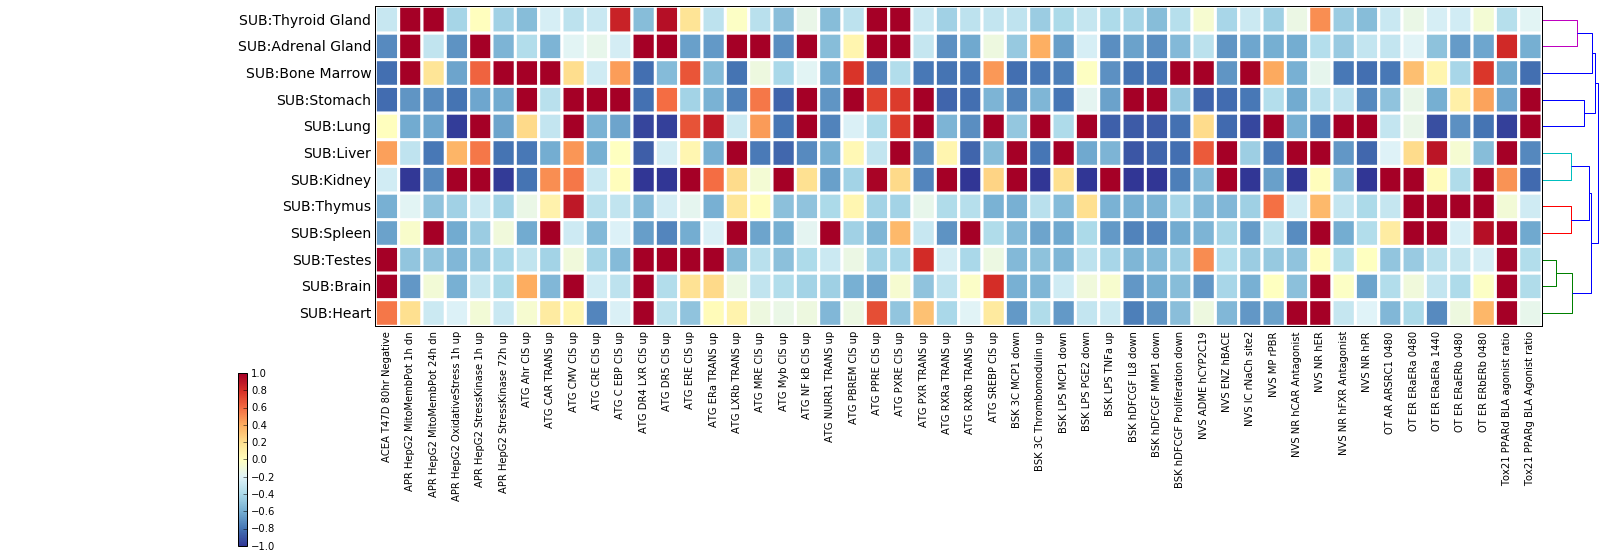

In [746]:
# 
# Visualize the associations between Liver Tox categories and informative descriptors
#

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.text as text
import matplotlib.font_manager as fm 
import pylab as pl
from matplotlib.patches import Ellipse, Circle, Rectangle
from collections import *
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist


import matplotlib.gridspec as gridspec
from sklearn import preprocessing

DF2 = pd.DataFrame(preprocessing.scale(TopBio2.fillna(0),axis=1,with_std=True),index=TopBio2.index,columns=TopBio2.columns)

fig = pl.figure(figsize=(23,6),dpi=600)

gs1 = gridspec.GridSpec(3,3,width_ratios=[0.1,2,0.1],height_ratios=[0.15,1,0.2])

# Cluster and visualize dendrogram for descriptors
#ax = pl.subplot(gs1[0,1])
#dnd_col=dendrogram(linkage(pdist(DF2.T,metric='cosine'),method='weighted'),orientation='top',no_plot=True)#,count_sort=True)
#ax.set_axis_off()

# Cluster and visualize dendrogram for toxicities
ax = pl.subplot(gs1[1,2])
dnd_row=dendrogram(linkage(pdist(DF2,metric='cosine'),method='average'),orientation='right')#,count_sort=True)
ax.set_axis_off()

# Visualize the distribution of values for descriptors

ax = pl.subplot(gs1[1,1])
dsc1 = sorted(DF2.columns)
X1=DF2.ix[dnd_row['leaves'],dsc1]
hm1=ax.pcolor(X1,cmap=cm.RdYlBu_r,edgecolor='white',lw=3,vmin=-1,vmax=1)
#hm1=ax.pcolor(X1,cmap=cm.plasma_r,edgecolor='white',lw=3)
ax.xaxis.tick_bottom()

ax.set_xticks(np.arange(len(dsc1))+0.5, minor=False)
xl=ax.set_xticklabels([i.replace('_',' ') for i in dsc1], minor=False,rotation=90)
for tick in ax.get_xticklines(): 
    tick.set_visible(False)
for tick in ax.get_xticklabels(): 
    tick.set_fontsize(10)


tox1 = DF2.index[dnd_row['leaves']]
ax.set_yticks(np.arange(len(tox1))+0.5, minor=False)
yl=ax.set_yticklabels(tox1, minor=False)

for tick in ax.get_yticklabels(): 
    tick.set_fontsize(14)
for tick in ax.get_yticklines(): 
    tick.set_visible(False)

ax.set_xlim(0,len(dsc1))
ax.set_ylim(0,len(tox1))

#ax = pl.subplot(gs1[2,2])
#pl.colorbar(hm1,ax=ax,shrink=3.0)
#ax.set_axis_off()

ax1 = fig.add_axes([-0.05,-0.2,0.15,0.08])
pl.colorbar(hm1,ax=ax1,shrink=5)
ax1.set_axis_off()

pl.subplots_adjust(wspace=0,hspace=0,top=1,bottom=0)
pl.savefig(FIG_DIR+'Figure-4.2.png',bbox_inches='tight')
pl.savefig(FIG_DIR+'Figure-4.2.svg',bbox_inches='tight')